# Safe Keras Notebook 
### First set some path variables: only developers should need to  change this   

In [1]:
import sys
import os

# from os.path import expanduser

# ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
# sys.path.append(ROOT_DIR)
# home = expanduser("~")
# sys.path.append(os.path.abspath(home + "/GitHub/AI-SDC/AI-SDC"))

sys.path.insert(0, os.path.abspath(".."))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_privacy as tf_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Safe Keras
from aisdc.safemodel.classifiers import SafeKerasModel

# set tensorflow messages to warning level
tf.get_logger().setLevel("WARNING")

## A Quick Start Guide to implementing Safer Keras Models
### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset and a shadow dataset drawn from the same distribution.
3. We also draw a dataset from a different distribution.

**NOTE**. ***we make datasets with few samples but with many features to force the target model to overfit.***


**NOTE**: batch_size 25 so DP optimizer would run with same hyperparams

**NOTE**: Next cell determines which dataset is used

In [23]:
simple_data_for_pytests = False

In [24]:
if not simple_data_for_pytests:
    n_classes = 2

    # (X,y): Original distribution
    X, y = make_classification(
        n_samples=1000,
        n_classes=n_classes,
        n_features=300,
        n_informative=300,
        n_redundant=0,
        n_repeated=0,
        random_state=15,
    )
    # One-hot encoding of the label
    y = np.eye(n_classes)[y]

    # (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
    # (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
    Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

    # (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
    Xd, yd = make_classification(
        n_samples=1000,
        n_classes=n_classes,
        n_features=300,
        n_informative=300,
        n_redundant=0,
        n_repeated=0,
        random_state=42,
    )
    yd = np.eye(n_classes)[yd]

    # Split into train (member) and test (non-member) datasets
    # Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
    # we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
    Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(
        Xt, yt, test_size=0.5, shuffle=False
    )

    # Set membership status for future tests
    Xt_membership = np.vstack(
        (
            np.ones((Xt_member.shape[0], 1), np.uint8),
            np.zeros((Xt_nonmember.shape[0], 1), np.uint8),
        )
    ).flatten()

    X = Xt_member
    y = yt_member
    Xval = Xt_nonmember
    yval = yt_nonmember

In [25]:
if simple_data_for_pytests:
    from sklearn import datasets

    def get_data():
        iris = datasets.load_iris()
        x = np.asarray(iris.data, dtype=np.float64)
        y = np.asarray(iris.target, dtype=np.float64)
        return x, y

    xall, yall = get_data()
    n_classes = 4
    X, Xval, y, yval = train_test_split(
        xall, yall, test_size=0.2, shuffle=True, random_state=12345
    )

    y = tf.one_hot(y, n_classes)
    yval = tf.one_hot(yval, n_classes)
# yval

## Define the target model architecture

*Again, we use a rather big model (for the classification task) to favour overfitting.*

In [27]:
# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)

# make results repeatable
tf.random.set_seed(12345)
initializer = tf.keras.initializers.GlorotUniform()

input_data = Input(shape=X[0].shape)
x = Dense(128, activation="relu", kernel_initializer=initializer)(input_data)
x = Dense(128, activation="relu", kernel_initializer=initializer)(x)
x = Dense(64, activation="relu", kernel_initializer=initializer)(x)
output = Dense(n_classes, activation="softmax", kernel_initializer=initializer)(x)

### Define the SafeModel

In [28]:
safeModel = SafeKerasModel(
    inputs=input_data,
    outputs=output,
    name="safekeras-test",
    num_samples=X.shape[0],
    epochs=10,
)

Preliminary checks: WARNING: model parameters may present a disclosure risk:
- parameter noise_multiplier = 0.5 identified as less than the recommended min value of 0.7.
Changed parameter noise_multiplier = 0.7.



### Set loss and compile

In [29]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE
)


safeModel.compile(loss=loss, optimizer=None)

During compilation: Changed parameter optimizer = 'DPKerasSGDOptimizer'


### Fit the model

DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 100 steps satisfies differential privacy with eps = 16.6 and delta = 1e-05.
The optimal RDP order is 2.0.


Epoch 1/10
10/10 [==============================] - 3s 255ms/step - loss: 2.4973 - accuracy: 0.5160 - val_loss: 2.6877 - val_accuracy: 0.4960
Epoch 2/10
10/10 [==============================] - 2s 237ms/step - loss: 2.0931 - accuracy: 0.5640 - val_loss: 2.6187 - val_accuracy: 0.4800
Epoch 3/10
10/10 [==============================] - 2s 244ms/step - loss: 1.8681 - accuracy: 0.5760 - val_loss: 2.7898 - val_accuracy: 0.4960
Epoch 4/10
10/10 [==============================] - 2s 240ms/step - loss: 1.7470 - accuracy: 0.6200 - val_loss: 2.9266 - val_accuracy: 0.4840
Epoch 5/10
10/10 [==============================] - 2s 240ms/step - loss: 1.5801 - accuracy: 0.6680 - val_loss: 3.0157 - val_accuracy: 0.4840
Epoch 6/10
10/10 [==============================] - 3s 256ms/step - loss: 1.3886 - accuracy: 0.6960 - val_los

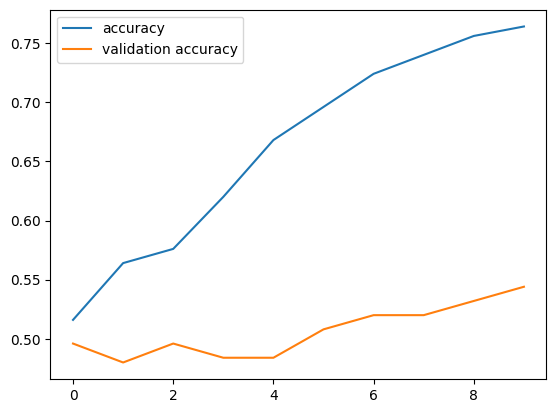

8/8 [==============================] - 0s 4ms/step
model training  report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79       117
           1       0.81      0.84      0.83       133

    accuracy                           0.81       250
   macro avg       0.81      0.81      0.81       250
weighted avg       0.81      0.81      0.81       250



In [30]:
epochs = 10
batch_size = 25

r_DP = safeModel.fit(
    X,
    y,
    validation_data=(Xval, yval),
    epochs=epochs,
    batch_size=batch_size,
)
if r_DP == None:
    print("You have chosen to exit. Reset relevant parameter values then re-run fit().")
else:
    plt.plot(r_DP.history["accuracy"], label="accuracy")
    plt.plot(r_DP.history["val_accuracy"], label="validation accuracy")
    plt.legend()
    plt.show()
    ypred = safeModel.predict(X)
    ylabels = np.argmax(y, axis=1)
    ypredlabels = np.argmax(ypred, axis=1)
    print(f"model training  report:\n {classification_report(ylabels,ypredlabels)}")

### Compute privacy and check if requirements for Differential Privacy are met

In [31]:
num_samples = X.shape[0]
batch_size = safeModel.batch_size
epochs = 20

dp_met, privacy = safeModel.dp_epsilon_met(
    num_examples=num_samples, batch_size=batch_size, epochs=epochs
)

print(f"with these settings privacy = {privacy}")

DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 200 steps satisfies differential privacy with eps = 23.1 and delta = 1e-05.
The optimal RDP order is 2.0.
with these settings privacy = 23.09099569905857


In [32]:
dp_met, msg = safeModel.check_epsilon(
    X.shape[0], safeModel.batch_size, safeModel.epochs
)
print(f"Satisfies DP: {dp_met}")
print(f"{msg}")

DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 100 steps satisfies differential privacy with eps = 16.6 and delta = 1e-05.
The optimal RDP order is 2.0.

Satisfies DP: False



### Check model and request release

Note that the request_release() process will fail if the version checkpointed
during the fit() call, is not present
- it should be in  "tfsaves/fit_model.tf" 

In [33]:
safeModel.save("safe1.tf")
safeModel.preliminary_check()
safeModel.request_release(path="safe1", ext="tf")

Preliminary checks: Model parameters are within recommended ranges.



DP-SGD with sampling rate = 10% and noise_multiplier = 0.7 iterated over 100 steps satisfies differential privacy with eps = 16.6 and delta = 1e-05.
The optimal RDP order is 2.0.
Recommendation is further discussion needed WARNING: epsilon 16.608813401454455 is above normal max recommended value.
Discussion with researcher needed.
.



### Examine Checkfile


In [34]:
target_json = os.path.normpath("safe1/target.json")
with open(target_json, "r") as f:
    print(f.read())

{
    "data_name": "",
    "n_samples": 0,
    "features": {},
    "n_features": 0,
    "n_samples_orig": 0,
    "generalisation_error": "unknown",
    "safemodel": [
        {
            "researcher": "j4-smith",
            "model_type": "KerasModel",
            "details": "Model parameters are within recommended ranges.\n",
            "recommendation": "Do not allow release",
            "reason": "Model parameters are within recommended ranges.\nRecommendation is not to release because None.\nWARNING: epsilon 16.608813401454455 is above normal max recommended value.\nDiscussion with researcher needed.\n",
            "timestamp": "2023-10-10 18:23:58"
        }
    ],
    "model_path": "model.tf",
    "model_name": "SafeKerasModel",
    "model_params": {}
}


## load saved model

### note that for security reasons we do not include the optimizer in the saved version
- This means that tensorflow will assume it has not beeen compiled
- so the loss and accuracy functions are not defined. 
- really urgent users can define losses if they want to use built-in evaluate functions
- or they can use standard methods to assess accuracy


In [35]:
from aisdc.safemodel.classifiers.safekeras import load_safe_keras_model

model_path = os.path.normpath("safe1/model.tf")
status, reloaded_model = load_safe_keras_model(model_path)

In [36]:
ypred = reloaded_model.predict(X)
ylabels = np.argmax(y, axis=1)
ypredlabels = np.argmax(ypred, axis=1)
reloaded_cm = confusion_matrix(ylabels, ypredlabels)
print(
    f"reloaded model training  accuracy:\n {classification_report(ylabels,ypredlabels)}"
)

8/8 [==============================] - 0s 4ms/step
reloaded model training  accuracy:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79       117
           1       0.81      0.84      0.83       133

    accuracy                           0.81       250
   macro avg       0.81      0.81      0.81       250
weighted avg       0.81      0.81      0.81       250

